In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

In [16]:
# range of L1 penalties to try 
lmbdas = [0., 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]
len(lmbdas)

10

In [17]:
# import file names
files = os.listdir("data/SET3_Thirdtrial/")
files

['CDanc_CDmono12h_PROVIDET0.csv', 'CDevo_CDmono12h_PROVIDET0.csv']

In [109]:
exp_names = []
# for file in files:
file = files[0]
    
# define strain name
strain = file.split("_")[0]
strain

'CDanc'

In [110]:
# import parameters
param_df = pd.read_csv(f"L1scan/{strain}_params.csv")

In [111]:
param_df

,parameter,0.0,1e-08,1e-07,1e-06,1e-05,0.0001,0.001,0.01,0.1,1.0
0,CA,0.178948,0.187316,0.202629,0.203139,0.179091,0.141965,0.145186,-0.000410,1.369882e-04,0.000014
1,BT,1.058464,1.059915,1.062566,1.061748,1.068541,1.085870,1.014499,0.676716,-8.650595e-05,-0.000170
2,BU,0.910414,0.920936,0.942916,0.911758,0.919268,0.913557,0.837688,0.001440,2.090891e-01,0.000118
3,CD,0.594207,0.615883,0.590263,0.596572,0.619871,0.597809,0.541413,0.188184,1.791965e-01,-0.000118
4,BV,0.766309,0.757114,0.782922,0.730403,0.753065,0.716366,0.660543,0.221967,2.053360e-05,-0.000158
...,...,...,...,...,...,...,...,...,...,...,...
235,CH<-[CD*CS],-4.783775,-3.427723,-3.959825,-3.834706,0.000627,-0.000035,-0.000103,0.000079,3.528925e-05,0.000002
236,CH<-[CD*DP],0.542324,2.142695,-0.077329,1.189536,0.002931,-0.001527,-0.000158,-0.000017,8.775741e-05,0.000131
237,CH<-[BV*CS],4.174923,4.335218,3.727202,3.584382,0.740907,0.002114,0.000206,-0.000002,-2.077408e-04,-0.000063
238,CH<-[BV*DP],-6.345647,-4.701699,-5.858508,-6.218590,-3.001402,-0.010679,0.000035,-0.000050,-4.490854e-04,-0.000017


In [112]:
hois = []
for p in param_df['parameter'].values:
    if '[' in p:
        hois.append(True)
    else:
        hois.append(False)

In [113]:
f'{lmbdas[5]}'

'0.0001'

In [114]:
hoi_vals = param_df.iloc[hois][f'{lmbdas[5]}'].values

In [115]:
hoi_nonzeros = param_df['parameter'].iloc[hois].values[np.abs(hoi_vals)>.5]
hoi_nonzeros

array(['CA<-[BT*CD]', 'CA<-[BU*CH]', 'CA<-[CD*CH]', 'BT<-[BU*BV]',
       'BU<-[BT*BV]', 'CD<-[BU*BV]', 'CD<-[BU*CH]', 'DP<-[BT*BU]',
       'CH<-[CD*BV]'], dtype=object)

In [116]:
len(hoi_nonzeros)

9

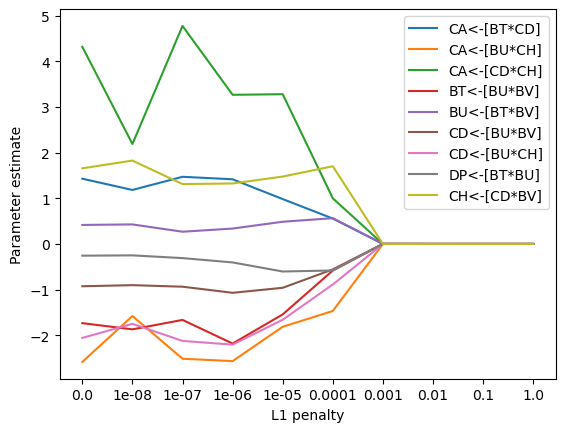

In [118]:
for hoi_nonzero in hoi_nonzeros:
    hoi_nonzero_scan = param_df.iloc[np.in1d(param_df['parameter'].values, hoi_nonzero)].values[0, 1:]
    plt.plot(hoi_nonzero_scan, label=hoi_nonzero)
plt.legend()
plt.xticks(np.arange(len(lmbdas)), [str(l) for l in lmbdas])
plt.ylabel("Parameter estimate")
plt.xlabel("L1 penalty")
plt.savefig(f"figures/{strain}_estimate_vs_l1.pdf", dpi=300)
plt.show()

In [94]:
# # evaluate prediction performance at each lmbda
# prediction_performance = []
# for lmbda in lmbdas:

#     # import measured and predicted values
#     pred_df = []
#     test_df = []
#     for i in range(20):
#         pred_df.append(pd.read_csv(f"Sulaiman_HOI_kfold/{strain}_preds/{strain}_pred_{i}_{lmbda}.csv"))
#         test_df.append(pd.read_csv(f"Sulaiman_HOI_kfold/folds_{strain}/test_{i}.csv"))
#     pred_df = pd.concat(pred_df)
#     test_df = pd.concat(test_df)

#     # species 
#     species = test_df.columns.values[2:]

#     # eval prediction performance for each species
#     r_vals = []
#     rmse_vals = []

#     for s in species:

#         measured_vals = []
#         predicted_vals = []

#         for t, df_t in test_df.groupby("Treatments"):

#             # get predictions for sample
#             pred_df_t = pred_df.iloc[np.in1d(pred_df.Treatments.values, t)].copy()

#             # true values
#             measured_val = df_t[s].values

#             # if species was inocuated
#             if measured_val[0] > 0:

#                 measured_vals.append(measured_val[1:])
#                 predicted_vals.append(pred_df_t[s].values[1:])

#         measured_vals = np.concatenate(measured_vals)
#         predicted_vals = np.concatenate(predicted_vals)

#         r_vals.append(pearsonr(measured_vals, predicted_vals)[0])
#         rmse_vals.append(np.sqrt(np.mean((measured_vals-predicted_vals)**2)))
        
#     # save average prediction performance for species
#     prediction_performance.append(np.mean(rmse_vals))

In [95]:
prediction_performance

[0.10336481667018851,
 0.07069887624860127,
 0.5540642654656052,
 0.06159262671033949,
 0.32876053276282874,
 0.059452288327911475,
 0.06870728031909859,
 0.2239251514312558,
 0.28494788438238394,
 0.30691778219030047]

In [96]:
lmbdas

[0.0, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]

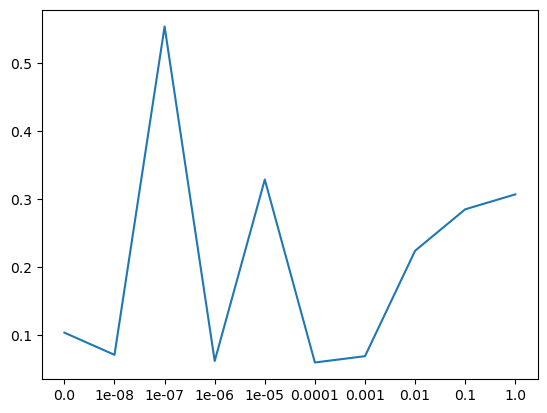

In [97]:
plt.plot(prediction_performance)
plt.xticks(np.arange(len(lmbdas)), [str(l) for l in lmbdas])
plt.show()